# Supplementary Analysis
## Chop-n-drop: *in silico* assessment of a novel single-molecule protein fingerprinting method employing fragmentation and nanopore detection
### Separation 4Da: [Met5]-enkephalin and [d-Ala2][d-Leu5]-enkephalin.

*This notebook was run using:*
 Windows 10 (64-bit) with 16 gb ram minimum and a AMD Ryzen 7 3750H CPU @ 2.30 GHz

###  <ins>Florian L. R. Lucas</ins>$^{1}$
$^{1}$_Groningen Biomolecular Sciences and Biotechnology Institute, University of Groningen, Groningen, Netherlands_  

# Before starting (first time), non-standard libraries.

Open __Anaconda Prompt__ in windows, this will open the anaconda terminal.
<br>
It should something like this:
~~~~
(base) C:\Users\user>
~~~~
Enter `pip install neo`, If it asks if you want to install, enter `Y` and press enter.
<br>
Wait untill it finished installing, you're ready to begin.

# Data Analysis
### Define folder path
We use a variable, `notebook_path`, to refer to the path folder.<br>
Change the `notebook_path` to the path of the folder.
##### Common errors:
> The drive name should be read with two slashes (e.g. C:\\\\).
>
> The path name should not be too long, make it shorter.

In [1]:
notebook_path = globals()['_dh'][0] + '/'

#### Parameters
Here we define the parameters used throughout the script.

>`n_bins` (*int*): The standard number of bins for making histograms
>
>`Fs` (*float*): Filter frequency in Hertz
>
>`minimal_dwelltime` (*float*): Minimal dwelltime of events in seconds
>
>`offset` (*float*): Ignore the first x seconds from traces
>
>`use_sNDF` (*boolean*): Fit super flat-top Normal Distribution Function if True, else don't

In [2]:
n_bins = 300 # The standard number of bins for making histograms
Fs = 5000 # Filter frequency in Hertz
minimal_dwelltime = 4e-4 # Minimal dwelltime of events in seconds
offset = 1.8 # Ignore the first x seconds from traces (required due to applied protocol)
use_sNDF = True # Fit super flat-top Normal Distribution Function if True, else don't

'''Set reload to "True" to reuse previously generated analysis files (not included in repo)'''
reload = False

### Load the required libraries
We use the following libraries:
>__System Standard__
>
>`sys` (version: *3.6.4*)<br>
>`logging` (version: *0.5.1.2*)<br>
>`warnings` (system default)<br>
>
>__From the Python Package Index__
>
>`NumPy` (version: *1.14.3*, import as: `np`)<br>
>`Pandas` (version: *0.23.0*, import as: `pd`)<br>
>`scipy` (version: *1.1.0*, import `signal.savgol_filter`)<br>
>`matplotlib` (version: *2.2.2*, import as `mpl`)<br>
>`seaborn` (version: *0.8.1*, import as `sns`)<br>
>`neo` (version: *0.6.1*)<br>
>
>__Supplementary Package(s)__
>
>`nanolyse` (import as `nl`)<br>
>`CollectData` <br>

In [3]:
# exec(open(notebook_path + "./python_scripts/imports.py").read())
'''Analysis libraries'''
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from scipy import signal
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

'''Plotting libraries'''
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

'''To enable logging, e.g. for warning and errors'''
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

'''Supress warnings, usually they just cloud jupyter-notebook, we can access all warnings using logging.'''
import warnings
warnings.filterwarnings('ignore')

'''Add custom libraries'''
import sys
sys.path.insert(0, notebook_path + "./python_scripts")
import nanolyse as nl

from CollectData import *

#### Normal Distribution Function (NDF)

In [4]:
def NDF(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

#### Set the standard excluded current (I<sub>ex</sub>) bins
Here, we define the bins used for the excluded current spectra. The data is binned in `n_bins + 1` bins, so the edges of the bins are `n_bins` long, as defined before in the script.

In [5]:
Iex_bins = np.linspace( 0, 100, n_bins + 1 )
Iex_edges = np.linspace( 0, 100, n_bins )

In [6]:
results_cols = ['Folder', 'Protein', 'Blank Signal', 'Signal', 'Iex BLANK', 
                'Iex SD2 BLANK', 'dwelltime BLANK', 'beta BLANK', 'fit params BLANK', 
                'Iex', 'Iex SD2', 'dwelltime', 'beta', 'fit params']

In [7]:
results_load_cols = ['Folder', 'Protein', 'Iex BLANK', 
                'Iex SD2 BLANK', 'dwelltime BLANK', 'beta BLANK', 'fit params BLANK', 
                'Iex', 'Iex SD2', 'dwelltime', 'beta', 'fit params']

### Loading the data
The following code loads the file locations and additional information into `main_index`.

The structure of the data files is registered in __'index.csv'__ contained in the data folder. 
In this file, we describe the peptide(s) that were measured as well as the folder location and the expected baseline / standard deviation.<br><br>
__Example of *./data/index.csv*__

|Name (string)|Folder (string)|Baseline (pA) (float)|Baseline Error (pA) (float)|
|---|---|---|---|
|Enkephalin|G13F-FraC/20200604_FraC_G13F_Enk_FL|-52.3|2|
|Enkephalin|G13F-FraC/20200604_FraC_G13F_Enk_RV|-47.1|1.4|
|Enkephalin|G13F-FraC/20200605_FraC_G13F_Enk_FL|-47.3|2|
|...|...|...|...|

In each __Folder__, there is another __'index.csv'__, explaining which files are with protein and which are without (blank).<br><br>
__Example of *./data/G13F-FraC/20200604_FraC_G13F_Enk_FL/index.csv*__

|blank (boolean)|fname (string)|
|---|---|
|True|20200604_1M_KCl_50mM_Citricacid_50mM_BTP_pH_38_FraC_G13F_70mV_FL_0000|
|False|20200604_1M_KCl_50mM_Citricacid_50mM_BTP_pH_38_FraC_G13F_70mV_10uM_MetEnk_AlaEnk_FL_0000|
|...|...|


In [8]:
index = pd.read_csv(notebook_path + './data/index.csv')

The results columns are loaded into the `results_cols` variable and a new instance of the `CollectData( notebook_path, results_cols, *args )` is made in method `CD`.

In [9]:
CD_peptides = CollectData(notebook_path, results_cols)

In [10]:
CD_peptides.collect_data(index, offset=offset, Fs=Fs, 
                         dwelltime=minimal_dwelltime, sNDF=use_sNDF, reload=reload)

The following function `CD.collect_results( main_index, results_load_cols, *args )` loads the results from the `main_index` structure.<br>
<br>
*__Notice:__ this can take some time, because it also checks if the results in the folder are not corrupted.*

In [11]:
results_peptides = CD_peptides.collect_results(index, results_load_cols)

The following function `CD.save_excel_results( notebook_path, main_index, Iex_bins, Iex_edges, offset, Fs, minimal_dwelltime, *args )` loads the results from the `main_index` structure, which is saved as __’results.pkl’__ file in the __’./data/’__ folder, and saves the I<sub>ex</sub>% and other important features in __'results_analysis.xlsx'__.

In [12]:
CD_peptides.save_excel_results(notebook_path, index, Iex_bins, Iex_edges, 
                               offset=offset, Fs=Fs, minimal_dwelltime=minimal_dwelltime)

In [13]:
results_peptides_combined = results_peptides.where( results_peptides.loc[:,'Protein'] == 'Enkephalin' ).dropna()
results_peptides_YGGFM = results_peptides.where( results_peptides.loc[:,'Protein'] == 'YGGFM' ).dropna()
results_peptides_YAGFL = results_peptides.where( results_peptides.loc[:,'Protein'] == 'YAGFL' ).dropna().tail(1)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


*Side note, trace (1) of YAGFL had a much lower baseline current and must be exlcuded*

In [14]:
'''Not elegant, but easy way to extract the excluded currents and dwell times'''
peptides_iex, peptides_dwt = np.array([]), np.array([])
for i, j in zip(results_peptides_combined['Iex'], results_peptides_combined['dwelltime']):
    peptides_iex = np.concatenate((peptides_iex, i))
    peptides_dwt = np.concatenate((peptides_dwt, j))

In [15]:
'''Not elegant, but easy way to extract the excluded currents and dwell times'''
peptides_iex_YGGFM, peptides_dwt_YGGFM = np.array([]), np.array([])
for i, j in zip(results_peptides_YGGFM['Iex'], results_peptides_YGGFM['dwelltime']):
    peptides_iex_YGGFM = np.concatenate((peptides_iex_YGGFM, i))
    peptides_dwt_YGGFM = np.concatenate((peptides_dwt_YGGFM, j))

In [16]:
'''Not elegant, but easy way to extract the excluded currents and dwell times'''
peptides_iex_YAGFL, peptides_dwt_YAGFL = np.array([]), np.array([])
for i, j in zip(results_peptides_YAGFL['Iex'], results_peptides_YAGFL['dwelltime']):
    peptides_iex_YAGFL = np.concatenate((peptides_iex_YAGFL, i))
    peptides_dwt_YAGFL = np.concatenate((peptides_dwt_YAGFL, j))
idx = np.where(peptides_iex_YAGFL>0.4)
peptides_iex_YAGFL = peptides_iex_YAGFL[idx]
peptides_dwt_YAGFL = peptides_dwt_YAGFL[idx]

Fit the peaks of the excluded current spectrum

In [17]:
'''Create a histogram vector from the excluded currents'''
y, _ = np.histogram(peptides_iex*100, bins=Iex_bins);

'''Fit  the first peak (constrained to ensure fit)'''
p0 = (200,60, 1);
popt_YGGFM, pcov = curve_fit(NDF, Iex_edges[60*3:67*3], y[60*3:67*3], p0=p0)

'''Fit  the second peak (constrained to ensure fit)'''
p0 = (250,70, 1);
popt_YAGFL, pcov = curve_fit(NDF, Iex_edges[68*3:], y[68*3:], p0=p0)

Calculate the $I_{ex}(\%)$ resolution such that:
>$R_s=2\frac{\sqrt{(\mu_1-\mu_2)^2}}{\sigma_1+\sigma_2}$
>>Where 
>>$R_s$ is the resolution. $\mu_n$ and $\sigma_n$ represent the peak center and standard deviation of peak $n$.

> __Note.__ $R_s$ is expressed as the variance between samples. $e.g.$ $R_s=4$ means a separation of $2\sigma$.

In [18]:
resolution = ( 2 *abs( popt_YGGFM[1] - popt_YAGFL[1] ) ) / ( abs( popt_YGGFM[2] ) + abs( popt_YAGFL[2] ) )

Next, make the figure

Text(-0.25, 1.1, 'C')

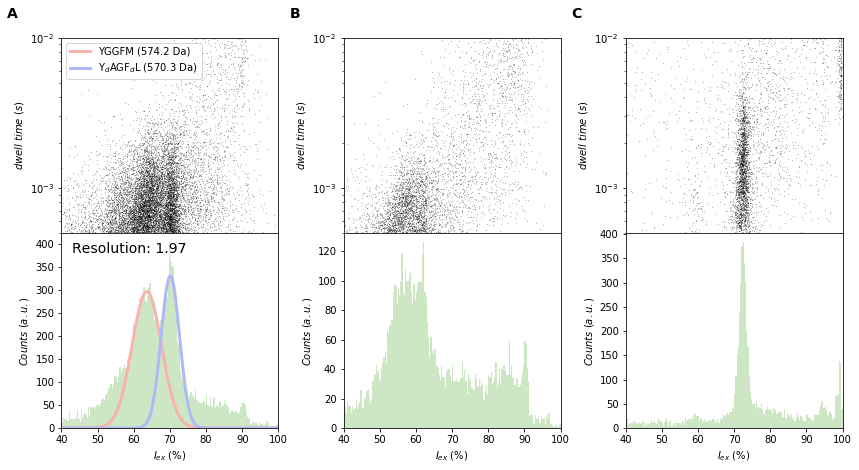

In [19]:
'''Setup figure'''
fig_size = (14, 7)
fontsize = 10
letter_font_size = 14
fig = plt.figure( figsize=fig_size )
gs = plt.GridSpec( 2, 3, top=0.9, wspace=0.3, hspace=0)
ax1 = fig.add_subplot( gs[ 0, 0 ] )
ax2 = fig.add_subplot( gs[ 1, 0 ] )

'''Set figure limits and ticks'''
ax1.set_xticks([])
ax1.set_ylim(5e-4, 1e-2)
ax1.set_xlim(40, 100)
ax1.set_yticks([5e-4, 1e-3, 1e-2])
ax2.set_xlim(40, 100)

'''Set figure axis labels'''
ax1.set_ylabel(r'$dwell$ $time$ $(s)$', fontsize=fontsize)
ax2.set_ylabel(r'$Counts$ $(a.u.)$', fontsize=fontsize)
ax2.set_xlabel(r'$I_{ex}$ $($%$)$', fontsize=fontsize)

'''Plot the excluded current vs dwell time in top figure'''
ax1.semilogy(peptides_iex*100, peptides_dwt, '.k', markersize=0.2)

'''Plot a histogram of the excluded currents'''
ax2.hist(peptides_iex*100, bins=np.linspace(0,100, 301), color="#CDE6C4")

'''Plot the fitted histograms for each peptide, and add a legend''' 
line1, = ax2.plot(Iex_edges, NDF(Iex_edges, *popt_YGGFM), color="#F9B3AF", lw=3)
line2, = ax2.plot(Iex_edges, NDF(Iex_edges, *popt_YAGFL), color="#B0B9F7", lw=3)
ax1.legend([line1, line2], [r'YGGFM (574.2 Da)', r'Y$_d$AGF$_d$L (570.3 Da)'], loc="upper left", fontsize=10)

'''Add the resolution as text'''
ax2.text( 0.05, 0.9, "Resolution: %s" % np.round(resolution, 2), transform=ax2.transAxes, size=letter_font_size )


ax3 = fig.add_subplot( gs[ 0, 1 ] )
ax4 = fig.add_subplot( gs[ 1, 1 ] )

'''Set figure limits and ticks'''
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_ylim(5e-4, 1e-2)
ax3.set_xlim(40, 100)
ax4.set_xlim(40, 100)

'''Set figure axis labels'''
ax3.set_ylabel(r'$dwell$ $time$ $(s)$', fontsize=fontsize)
ax4.set_ylabel(r'$Counts$ $(a.u.)$', fontsize=fontsize)
ax4.set_xlabel(r'$I_{ex}$ $($%$)$', fontsize=fontsize)

'''Plot the excluded current vs dwell time in top figure'''
ax3.semilogy(peptides_iex_YGGFM*100, peptides_dwt_YGGFM, '.k', markersize=0.2)

'''Plot a histogram of the excluded currents'''
ax4.hist(peptides_iex_YGGFM*100, bins=np.linspace(0,100, 301), color="#CDE6C4")


ax5 = fig.add_subplot( gs[ 0, 2 ] )
ax6 = fig.add_subplot( gs[ 1, 2 ] )

'''Set figure limits and ticks'''
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_ylim(5e-4, 1e-2)
ax5.set_xlim(40, 100)
ax6.set_xlim(40, 100)

'''Set figure axis labels'''
ax5.set_ylabel(r'$dwell$ $time$ $(s)$', fontsize=fontsize)
ax6.set_ylabel(r'$Counts$ $(a.u.)$', fontsize=fontsize)
ax6.set_xlabel(r'$I_{ex}$ $($%$)$', fontsize=fontsize)

'''Plot the excluded current vs dwell time in top figure'''
ax5.semilogy(peptides_iex_YAGFL*100, peptides_dwt_YAGFL, '.k', markersize=0.2)

'''Plot a histogram of the excluded currents'''
ax6.hist(peptides_iex_YAGFL*100, bins=np.linspace(0,100, 301), color="#CDE6C4")


ax1.text( -.25, 1.1, "A", transform=ax1.transAxes, size=14, weight='bold' )
ax3.text( -.25, 1.1, "B", transform=ax3.transAxes, size=14, weight='bold' )
ax5.text( -.25, 1.1, "C", transform=ax5.transAxes, size=14, weight='bold' )


__Figure. Excluded current of two peptides with a difference in mass of 4 Da. A.__ The top panel shows the excluded current set against the dwell time of events observed in a mixture of [Met5]-Enkephalin and [d-Ala2][d-Leu5]-Enkephalin added in equimolar concentrations. The bottom panel shows the excluded current histogram of the top panel with [Met5]-Enkephalin (YGGFM) and [d-Ala2][d-Leu5]-Enkephalin (YdAGFdL). The resolution was calculated by dividing the differences between the peak centres with the average standard deviation of the two peaks. __B.__ The top panel shows the excluded current set against the dwell time of events observed of [Met5]-Enkephalin. The bottom panel shows the excluded current histogram of the top panel with [Met5]-Enkephalin (YGGFM). __C.__ The top panel shows the excluded current set against the dwell time of events observed of [d-Ala2][d-Leu5]-Enkephalin. The bottom panel shows the excluded current histogram of the top panel with [d-Ala2][d-Leu5]-Enkephalin (YdAGFdL). Experiments were performed using G13F-FraC-T2 in 1 M KCl buffered to pH 3.8 using 50 mM citric acid titrated with bis-tris-propane. A potential of -70 mV was applied and recorded at 50 kHz, filtered using an analogue Bessel-filter at 10 kHz and a digital Gaussian filter at 5 kHz. The final concentration of all both peptides was 10 µM, however, recording time varies between 2 and 10 minutes.

In [20]:
fig.savefig('Figure.png', format='png', dpi=1200, bbox_inches = "tight")

# Fine